# Comparison of two population proportions between two groups


To compare the shift in cell population proportions between two groups we will build upon a multinomial regression model with ...

In [27]:
%matplotlib inline

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

In [28]:
SEED = 383561
np.random.seed(SEED) # from random.org, for reproducibility

## Realword example

Data have benn optained from Sophie.


In [3]:
# load data:
df = pd.read_csv("groups_all_counts.csv").set_index("sample")

#cell count matrix per condition
m1_data = df.iloc[0:3, :].as_matrix()
m2_data = df.iloc[3:, :].as_matrix()

#total number of cells per replica and condition
m1_total = m1_data.sum(axis=1)
m2_total = m2_data.sum(axis=1)

# number of cell types (should be the same accross conditions)
c = m1_data.shape[1]


/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


## Cell-cell correlation model
.. a logit-normal prior to model the correlations between cells and to crrect for confounders
Th emodel will roughly look like this:
    
\begin{align}
    \mathbf{y}_c &\sim \text{Multinomial}(\hat{c}_\text{total}, \tau_c)\\ 
    \mathbf{\tau}_c &\sim \text{MvLogitNormal}(X\theta, \Sigma )\\
    \Sigma &= LL^T\\
    L &\sim \text{LKJCholeskyCov}(\eta = 2, \sigma_L^2)\\
    \sigma_L^2 & \sim \text{HalfCauchy}(2.5)\\
    \mathbf{\theta} &\sim \text{MvNormal}(0, \sigma_\theta^2I)\\
    \sigma_\theta^2 & \sim \text{HalfCauchy}(2.5)\\
\end{align}


This model has quite bad convergence as we are fitting a low dimentional matrix vactorization of the full convariance matrix.

/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: DEPRECATION: If x is a vector, Softmax will not automatically pad x anymore in next releases. If you need it, please do it manually. The vector case is gonna be supported soon and the output will be a vector.
/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result

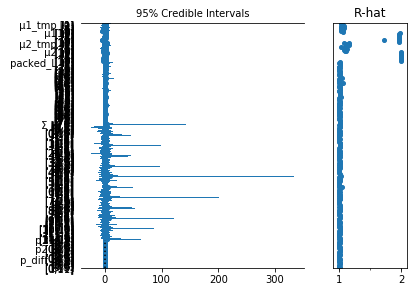

In [73]:
# This is the complicated model (accounting for cell-cell correlation)

with pm.Model() as softmax_model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=c,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(c, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))
    
    m1_tmp = pm.Normal('μ1_tmp', 0., 5., shape=c)
    mu1 = pm.MvNormal("μ1", m1_tmp, chol=L, shape=c)
    
    
    m2_tmp = pm.Normal('μ2_tmp', 0., 5., shape=c)
    mu2 = pm.MvNormal("μ2", m2_tmp, chol=L, shape=c)
    

    p1 = pm.Deterministic('p1', tt.nnet.softmax(mu1))
    p2 = pm.Deterministic('p2', tt.nnet.softmax(mu2))

    F1 = pm.Multinomial('F1', m1_total, p1, observed = m1_data)
    F2 = pm.Multinomial('F2', m2_total, p2, observed = m2_data)

    p_diff = pm.Deterministic("p_diff", p1 - p2)
    
    trace_sm = pm.sample(random_seed=SEED, cores=4, init="advi")#, sample=20000, tune=5000)
    pm.forestplot(trace_sm)

/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


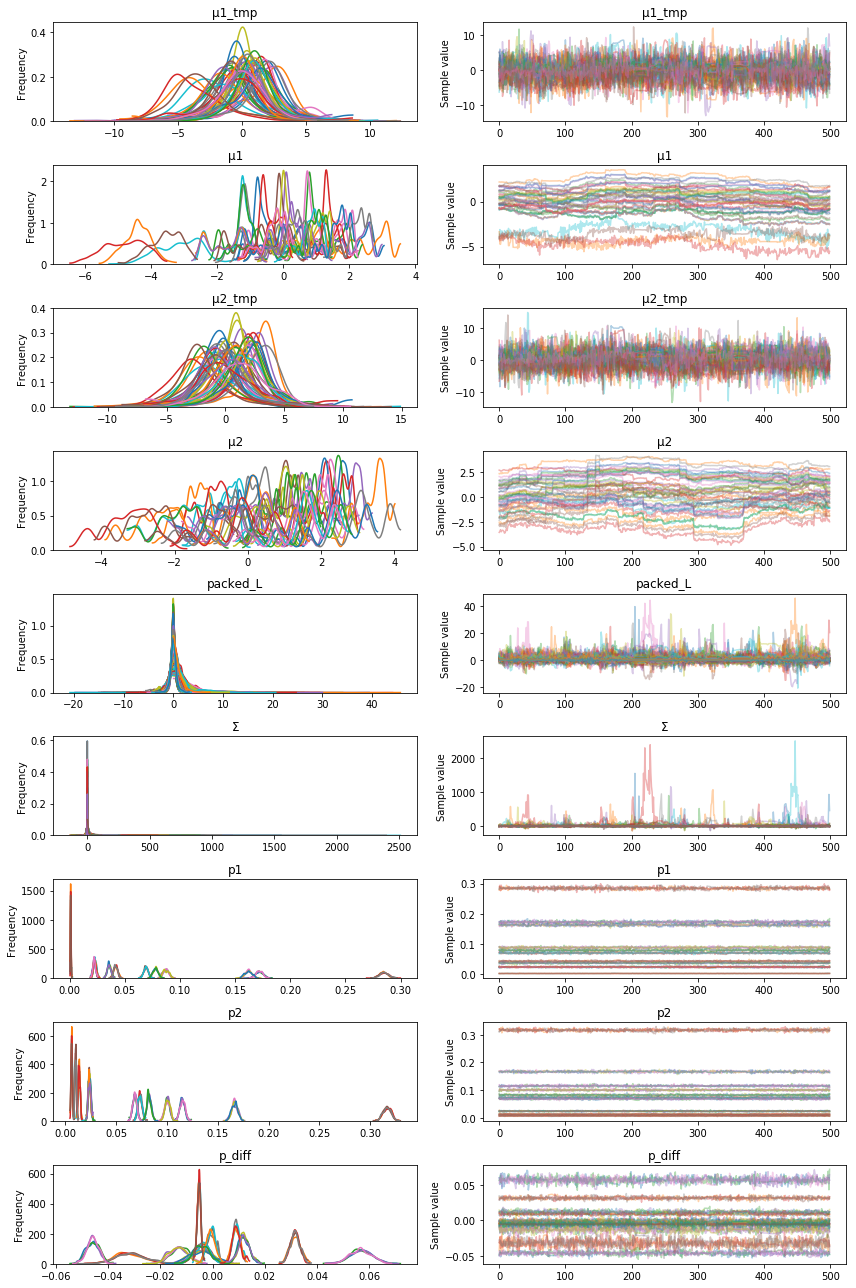

In [75]:
pm.traceplot(trace_sm);

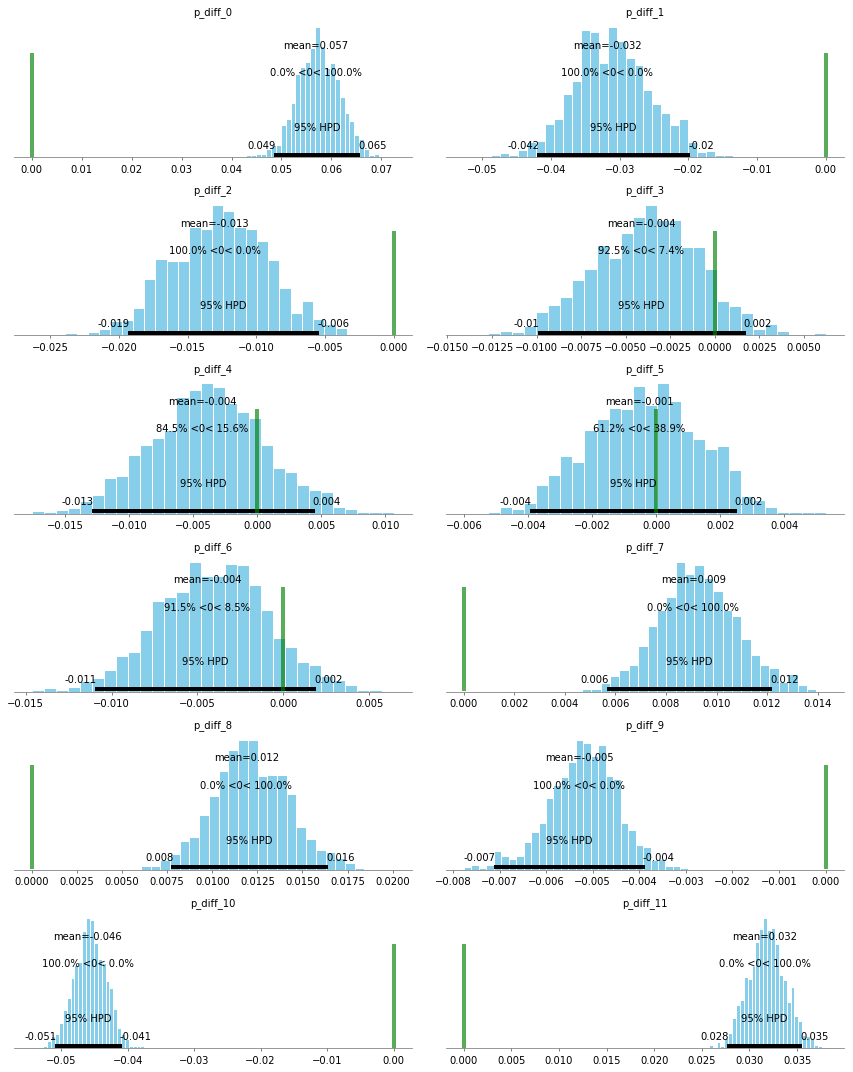

In [77]:
pm.plot_posterior(trace_sm, varnames=['p_diff'],ref_val=0, color='#87ceeb');

## Multinomial Dirchlet model
.. and a splice Dirichlet-Multinomial model:


\begin{align}
    \mathbf{p}_c &\sim \text{Dirichlet}(1)\\
    \mathbf{y}_c &\sim \text{Multinomial}(\hat{c}_\text{total}, p_c)\\ 
    \mathbf{p_{\text{diff}}} &= \mathbf{p}_1 - \mathbf{p}_2  
\end{align}
    
with good convergence.



Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 800.85:   7%|▋         | 13529/200000 [00:07<01:46, 1753.94it/s]
Convergence achieved at 13600
Interrupted at 13,599 [6%]: Average Loss = 3,456
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:26<00:00, 845.30draws/s]


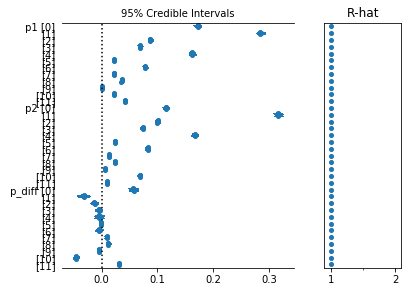

In [163]:
# this is the simple model

with pm.Model() as softmax_model:

    p1 = pm.Dirichlet('p1', np.ones(c), shape=c)
    p2 = pm.Dirichlet('p2', np.ones(c), shape=c)

    F1 = pm.Multinomial('F1', m1_total, p1, observed = m1_data)
    F2 = pm.Multinomial('F2', m2_total, p2, observed = m2_data)

    p_diff = pm.Deterministic("p_diff", p1 - p2)
    
    trace_sm = pm.sample(random_seed=SEED, cores=4, init="advi", sample=20000, tune=5000)
    pm.forestplot(trace_sm)

/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


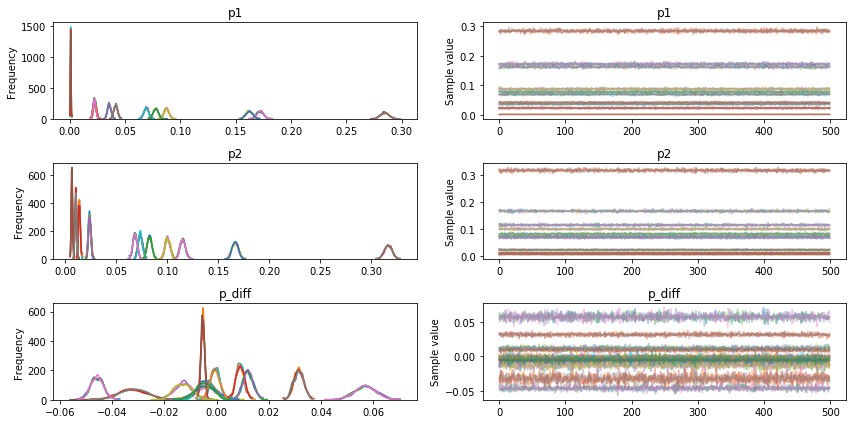

In [164]:
pm.traceplot(trace_sm);

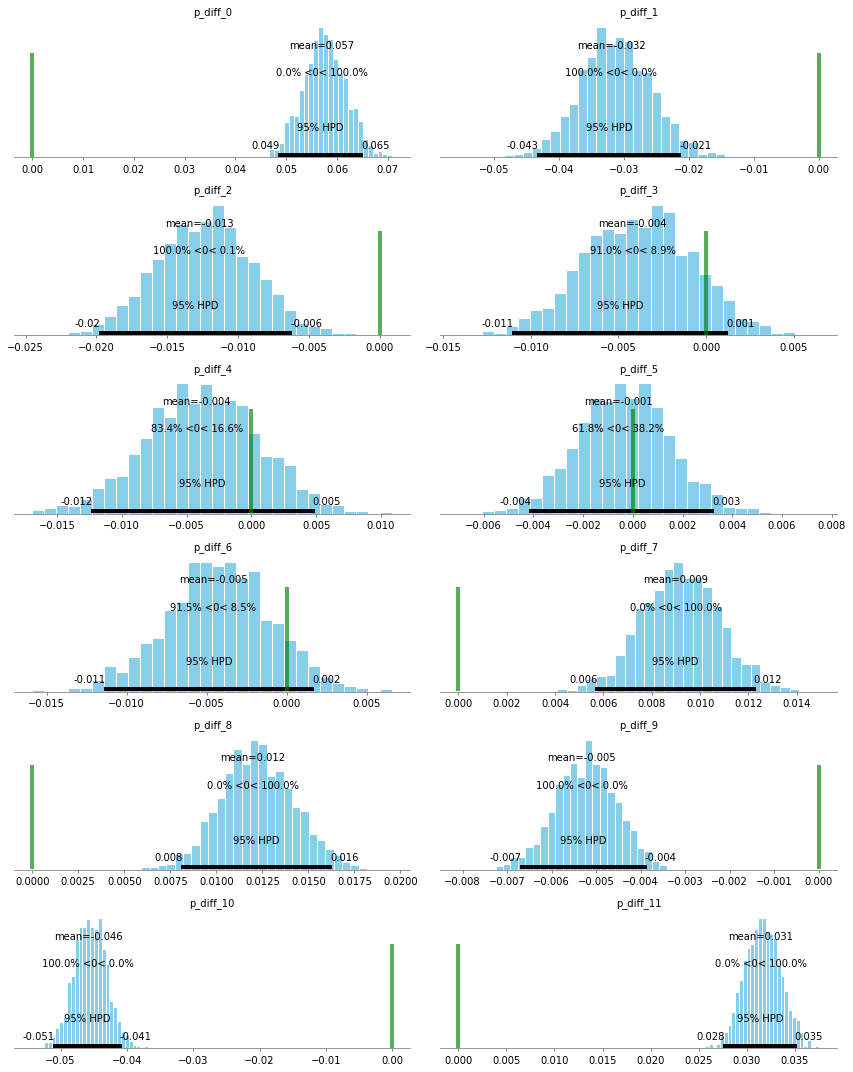

In [165]:
pm.plot_posterior(trace_sm, varnames=['p_diff'],ref_val=0, color='#87ceeb');

In [166]:
cells = df.columns
new_idx = []
summ = summ = pm.summary(trace_sm)
condition = []
param_type = []
for i,row in summ.iterrows():
    condition.append("HFD" if i.startswith("p2") else "CD")

    splits = i.split("_")
    param_type.append("p_diff" if i.startswith("p_diff") else "p")
    new_idx.append(cells[int(splits[-1])])
    
    
df2 = summ
df2 = df2.reset_index()
df2["condition"] = condition
df2["parameter"] = param_type
df2["cell_type"]= new_idx
df2 = df2.drop("index",axis=1)
df2.head()
            



,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat,condition,parameter,cell_type
0,0.172057,0.003220,0.000048,0.165654,0.178265,3389.142945,1.000154,CD,p,ISC
1,0.284532,0.003906,0.000090,0.277131,0.292079,2239.769131,0.999031,CD,p,Enterocyte progenitor
2,0.087468,0.002339,0.000044,0.083047,0.092334,3503.519231,0.999172,CD,p,Enterocyte
3,0.069264,0.002151,0.000039,0.064836,0.073435,3179.469105,0.999244,CD,p,Goblet progenitor
4,0.162324,0.003109,0.000052,0.156636,0.168700,3159.533216,0.999374,CD,p,Goblet cell


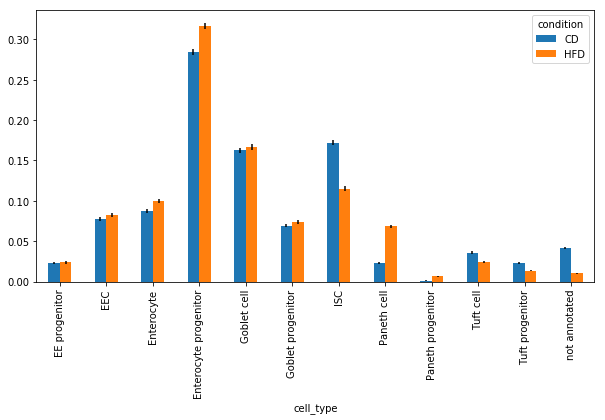

In [185]:
d = df2[df2.parameter == "p"]
plot = d.pivot("cell_type", "condition", "mean").plot(kind='bar', yerr=d.pivot("cell_type", "condition", "sd"))

[Text(0, 0, 'ISC'),
 Text(0, 0, 'Enterocyte progenitor'),
 Text(0, 0, 'Enterocyte'),
 Text(0, 0, 'Goblet progenitor'),
 Text(0, 0, 'Goblet cell'),
 Text(0, 0, 'EE progenitor'),
 Text(0, 0, 'EEC'),
 Text(0, 0, 'Tuft progenitor'),
 Text(0, 0, 'Tuft cell'),
 Text(0, 0, 'Paneth progenitor'),
 Text(0, 0, 'Paneth cell'),
 Text(0, 0, 'not annotated')]

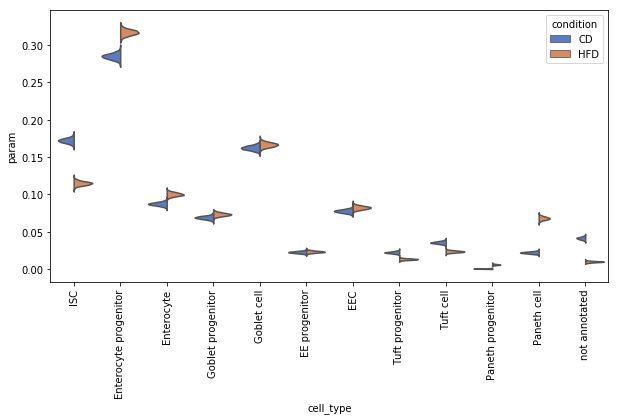

In [190]:
# use the entire sampled trace to plot the distirbutions
#p1 = 
n,k = trace_sm.p1.shape
cell = []
for _ in range(n):
    for c in df.columns:
        cell.append(c)
cell_idx = cell + cell
cond = ["CD"]*(k*n)+["HFD"]*(k*n)
dt = {"param":np.concatenate((trace_sm.p1.flatten(), trace_sm.p2.flatten())), 
       "cell_type":cell_idx, 
      "condition":cond}
df_trace = pd.DataFrame.from_dict(dt)
df_trace.head()
ax = sns.violinplot(x="cell_type", y="param", hue="condition", inner=None, data=df_trace, palette="muted", split=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## Multinomial regression model similar to DirchiletReg

for this model Im fitting not explicitly the mixing proportions of the multinomial but rather treat the condition as independent variable in a linear regression model:

\begin{align}
\tau &\sim~\text{HalfCauchy}(5)\\
\alpha_k&\sim~\text{Normal}(0, 10)\\
\beta_k&\sim~\text{Normal}(0, 5)\\
\mu_k &= \tau(\alpha_k + X\beta_k)\\
\mathbf{y} &\sim~\text{Multinomial}(\sum_k y_k, \text{softmax}(\mathbf{\mu}))\\
\end{align}



/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [beta_raw, sigma_beta, omega, alpha, dispersion]
>BinaryGibbsMetropolis: [pi]
Sampling 4 chains: 100%|██████████| 22000/22000 [05:53<00:00, 62.24draws/s] 
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The accept

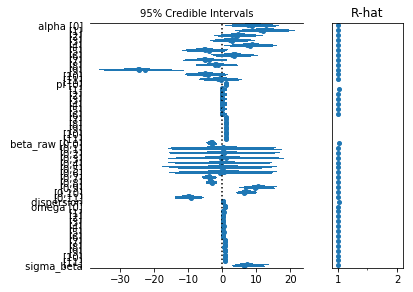

In [30]:
#regression model
df = pd.read_csv("groups_all_counts.csv").set_index("sample")

x = np.array([[0,0,0,1,1,1]]).T
m_data = df.as_matrix()
m_total = df.sum(axis=1)
k = 6
c = m_data.shape[1]
with pm.Model() as softmax_model:
    dispersion = pm.HalfCauchy('dispersion', beta=5, testval=1., shape=1)
    alpha = pm.Normal('alpha', 0., 10, shape=c)
    
    
    omega = pm.Beta("omega", 1, 1, shape=c)
    pi = pm.Bernoulli("pi", omega, shape=c)
    simga_beta = pm.HalfCauchy("sigma_beta", 5)
    beta_raw = pm.Normal("beta_raw", 0, simga_beta, shape=(1, c))

    mu = dispersion*(alpha + pm.math.dot(x,pi*beta_raw))

    F = pm.Multinomial('F', m_total, tt.nnet.softmax(mu), observed = m_data)

    trace_sm = pm.sample(random_seed=SEED, cores=4, sample=20000, tune=5000)
    pm.forestplot(trace_sm)

In [31]:
for i in range(c):
    print("K=%i P(inclusion)=%f3"%(i, sum(trace_sm.pi[:,i]>0.5)/len(trace_sm.pi[:,i])))
    

K=0 P(inclusion)=1.0000003
K=1 P(inclusion)=0.1335003
K=2 P(inclusion)=0.1370003
K=3 P(inclusion)=0.0555003
K=4 P(inclusion)=0.2425003
K=5 P(inclusion)=0.0940003
K=6 P(inclusion)=0.0460003
K=7 P(inclusion)=1.0000003
K=8 P(inclusion)=1.0000003
K=9 P(inclusion)=1.0000003
K=10 P(inclusion)=1.0000003
K=11 P(inclusion)=1.0000003


In [21]:
from scipy.stats import norm

for i in range(c):
    print("K=%i p-value=%f3"%(i, norm.sf(abs((np.mean(trace_sm.beta[:,0,i]) - 0.0)/np.std(trace_sm.beta[:,0,i]))) ))
    

AttributeError: 'MultiTrace' object has no attribute 'beta'

/home/benjamin/miniconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


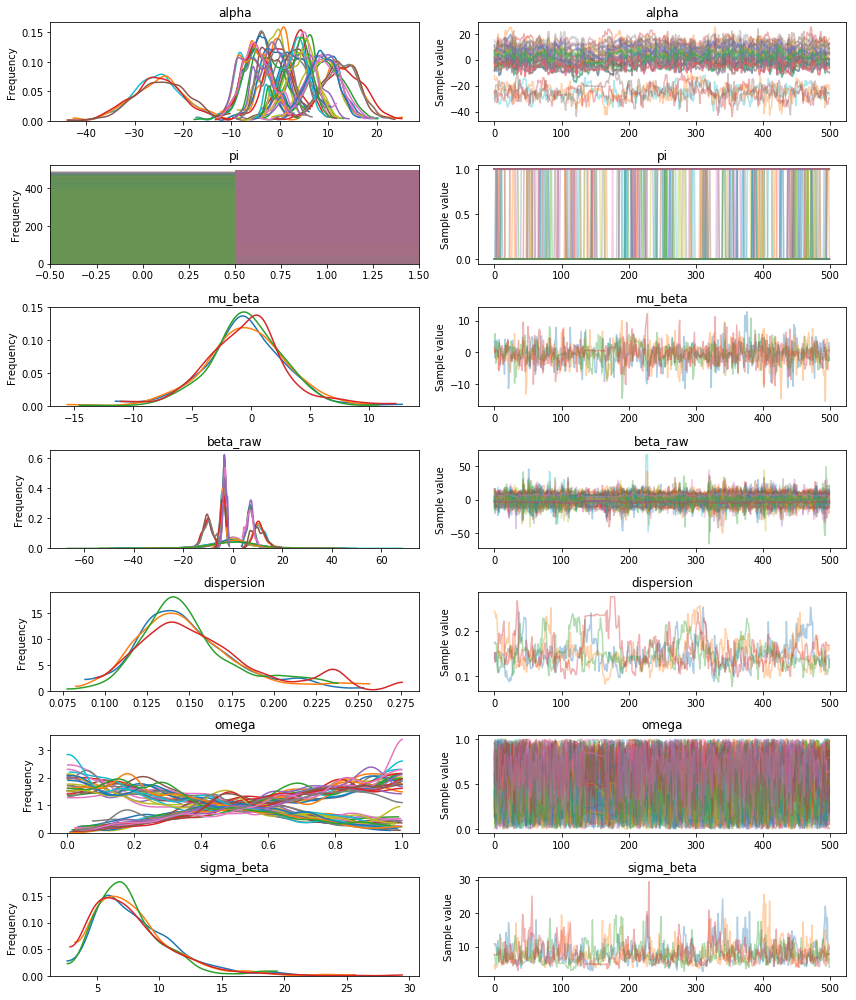

In [16]:
pm.traceplot(trace_sm);

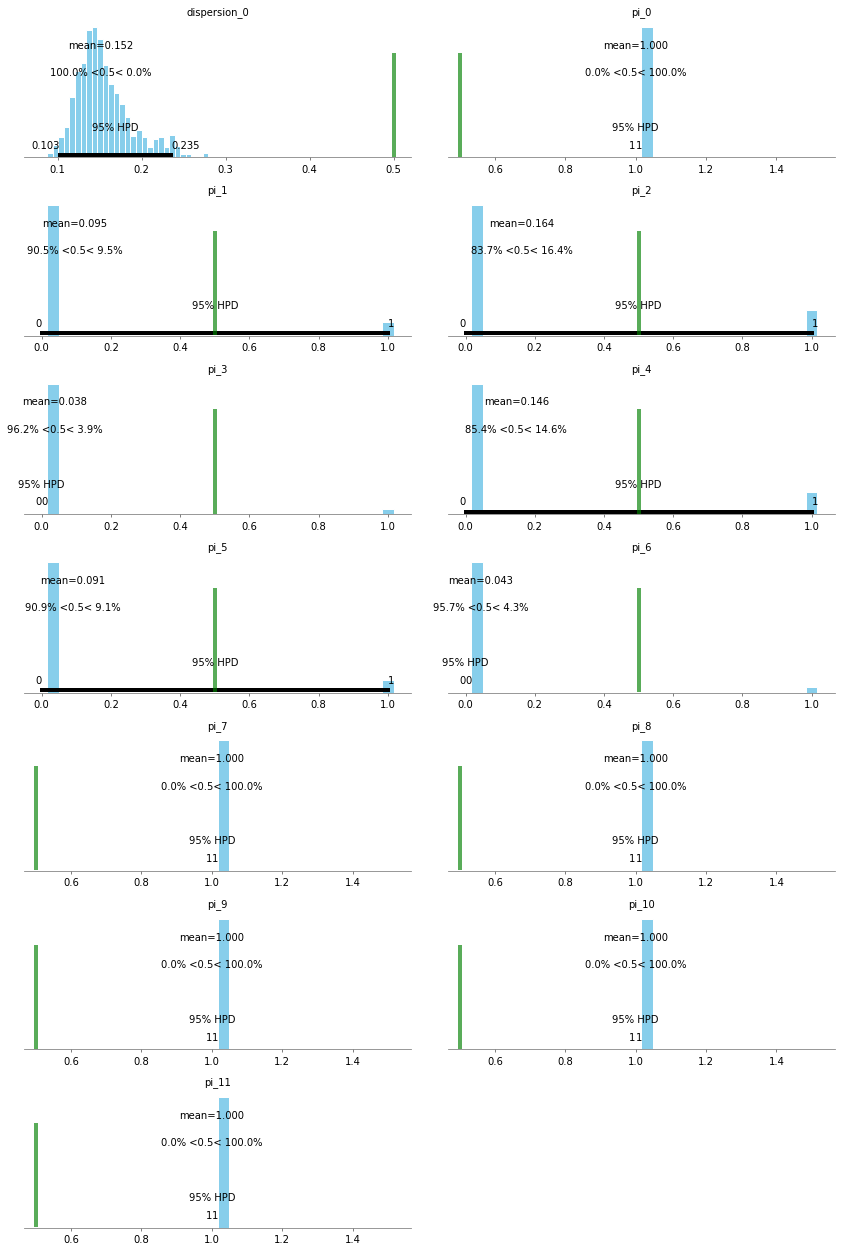

In [26]:
pm.plot_posterior(trace_sm, varnames=['dispersion','pi'],ref_val=0.5, color='#87ceeb');

# Full regression model with spike-and-slab prior for feature selection and parameter testing




Using a DirichletMultinomial model with log-link function for the covariats and a random effect to model within-subject correlation. We model the observed count data $y_{ij}$ of cell populations $j=1...m$ of individuals $i=1...n$, populations as DirichletMultinomial for $N_i$ observed total cells, and $\gamma_{ij}$ mean abundance. The abundance is dependent on $k$ covariates $x_k =1...k$.



In [29]:
import theano.tensor as tt
from pymc3.distributions.dist_math import gammaln, bound, factln

class DirichletMultinomial(pm.Discrete):
    def __init__(self, n, a, *args, **kwargs):
        super(DirichletMultinomial, self).__init__(*args, **kwargs)

        self.K = tt.as_tensor_variable(a.shape[-1])
        self.n = tt.as_tensor_variable(n[:, np.newaxis])

        if a.ndim == 1:
            self.alphas = tt.as_tensor_variable(a[np.newaxis, :])  # alphas[1, #classes]
        else:
            self.alphas = tt.as_tensor_variable(a)  # alphas[#samples, #classes]

        self.A = self.alphas.sum(axis=-1, keepdims=True)  # A[#samples]
        self.mean = self.n * (self.alphas / self.A)

        self.mode = tt.cast(pm.math.tround(self.mean), 'int32')

    def logp(self, value):
        printing = False
        k = self.K
        a = self.alphas
        A = self.A
        n = self.n
        res = bound(tt.squeeze(factln(n) + gammaln(A) - gammaln(A + n) +
                               tt.sum(gammaln(a + value) - gammaln(a) - factln(value), keepdims=True, axis=-1)),
                    tt.all(value >= 0),
                    tt.all(tt.eq(tt.sum(value, axis=-1, keepdims=True), n)),
                    tt.all(a > 0),
                    k > 1,
                    tt.all(tt.ge(n, 0)),
                    broadcast_conditions=False
                    )
        return res

\begin{align}
y_i &\sim~\text{DirichletMultinomial}(N_i,\gamma_i)\\
\log(\gamma_{ij}) &\sim~\beta_{0j}+x_i^T\beta_j+V_{ij}\\
V_i &\sim~\text{MvNormal}(\mathbf{0},\Sigma)\\
\Sigma&\sim~\text{Inv-Wishart}(\Psi_0, \rho_0)\\
\beta_{0}&\sim~\text{MvNormal}(\mu_0,\sigma_0^2I_0)\\
\beta_{jk}&\sim~\pi_{jk}\text{Normal}(0,\nu_{\beta j}^2\sigma_{\beta k}^2)+(1-\pi_{jk})\delta_0\\
\nu_{\beta j} &\sim~\text{HalfCauchy}(2.5)\\
\pi_{jk}&\sim~\text{Bernoulli}(\omega_{jk})\\
\omega_{jk}&\sim~\text{Beta}(1,1)\\
\end{align}


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [log_gamma, beta_offset, sigma_beta, omega, alpha_offset, sigma_alpha, packed_L]
>BinaryGibbsMetropolis: [pi]
Sampling 2 chains: 100%|██████████| 8000/8000 [39:25<00:00,  1.88draws/s]
There were 543 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 609 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


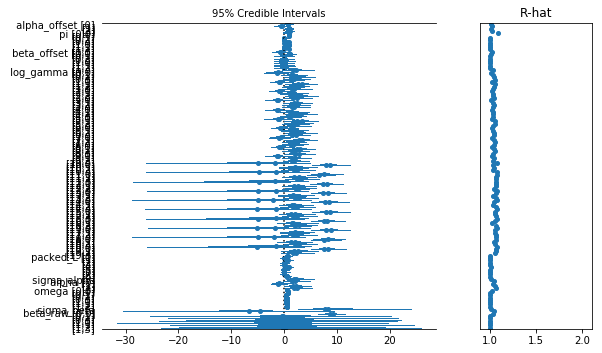

In [30]:
from theano import *
import theano.tensor as T
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=1)[:,None]

n = 20 # sample
m = 4  # population
k = 2   # covariates


#generate some simulation data to test

# mean intercept of cell populations
alphas = np.random.standard_normal(m)

# random effect (no correlation)
Cov = np.eye(m)
V = np.random.multivariate_normal(np.zeros(m), Cov, size=n)

# No covariat effect
# only one effect 
X = np.random.randint(0,1,size=(n,k))
X[0:int(n/2),0] = np.zeros(int(n/2))
X[int(n/2):,0] = np.ones(int(n/2))
beta = np.zeros((k,m))
beta[0, 1] = np.random.normal(10, 0.5)

p = softmax(alphas + np.dot(X,beta)+V)
data = np.zeros((n,m))
for i in range(n):
    data[i,:] = np.random.multinomial(100, p[i,:], size=1)
n_total = np.array([100]*n)


with pm.Model() as spike_and_slab:

    #random effect
    packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(m, packed_L)
    # plot correlation matrix
    #Σ = pm.Deterministic('Σ', L.dot(L.T))
    #V = pm.MvNormal("V", 0, chol=L, shape=(n,m))
    
    #intercept
    sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)
    alpha = pm.Normal("alpha", 0, sigma_alpha, shape=m)
    
    
    #fixed effect
    omega = pm.Beta("omega", 1, 1, shape=(k,m))
    pi = pm.Bernoulli("pi", omega, shape=(k,m))
    sigma_beta = pm.HalfCauchy("sigma_beta", 5)
    beta_raw = pm.Normal("beta_raw", 0, sigma_beta, shape=(k, m))

    
    log_gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, pi*beta_raw), chol=L, shape=(n,m))
    #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
    F1 = DirichletMultinomial('likelihood', n_total, 
                              pm.math.exp(log_gamma), 
                              observed = data)
 

with pm.Model() as spike_and_slab_non_centered:

    #random effect
    packed_L = pm.LKJCholeskyCov('packed_L', n=m,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(m, packed_L)
    # plot correlation matrix
    #Σ = pm.Deterministic('Σ', L.dot(L.T))
    #V = pm.MvNormal("V", 0, chol=L, shape=(n,m))
    
    #intercept
    sigma_alpha = pm.HalfCauchy("sigma_alpha", 5)

    alpha_offset = pm.Normal("alpha_offset", 0,1, shape=m)
    alpha = pm.Deterministic("alpha", alpha_offset*sigma_alpha)
    
    #fixed effect
    omega = pm.Beta("omega", 1, 1, shape=(k,m))
    pi = pm.Bernoulli("pi", omega, shape=(k,m))
    

    sigma_beta = pm.HalfCauchy("sigma_beta", 5)
    beta_offset = pm.Normal("beta_offset", 0, 1, shape=(k,m))
    beta_raw = pm.Deterministic("beta_raw", sigma_beta*beta_offset)

    
    log_gamma = pm.MvNormal("log_gamma", alpha + pm.math.dot(X, pi*beta_raw), chol=L, shape=(n,m))
    #log_gamma = alpha + pm.math.dot(X, pi*beta_raw) + V
    F1 = DirichletMultinomial('likelihood', n_total, 
                              pm.math.exp(log_gamma), 
                              observed = data)

    
with spike_and_slab_non_centered:
    trace_sm = pm.sample(3000,
                         random_seed=SEED, 
                         init="auto", 
                         cores=4, 
                         tune=1000, 
                         chains=2, 
                         tree_depth=20, 
                         target_accept=0.90)#, sample=20000, tune=5000)
    pm.forestplot(trace_sm)

In [31]:
pm.summary(trace_sm)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha_offset__0,0.754522,0.420408,0.023183,-0.023038,1.587370,112.999136,1.012762
alpha_offset__1,-0.562666,0.573957,0.038720,-1.728284,0.425760,73.371320,1.025966
alpha_offset__2,0.908063,0.422991,0.019090,0.134198,1.803989,216.260608,1.012190
alpha_offset__3,0.996545,0.431972,0.018416,0.174087,1.828165,178.986254,1.021660
pi__0_0,0.836333,0.369973,0.033167,0.000000,1.000000,24.053121,1.093678
pi__0_1,1.000000,0.000000,0.000000,1.000000,1.000000,NaN,NaN
pi__0_2,0.149667,0.356744,0.018471,0.000000,1.000000,269.502743,0.999889
pi__0_3,0.166000,0.372081,0.023912,0.000000,1.000000,126.396476,1.002176
pi__1_0,0.499667,0.500000,0.009348,0.000000,1.000000,3431.372734,1.000442
pi__1_1,0.518500,0.499658,0.010535,0.000000,1.000000,2859.052182,0.999858


In [32]:
for i in range(m):
    for j in range(k):
        print("Species=%i, Covariat=%i = P(inclusion)=%f3"%(i,j, sum(trace_sm.pi[:,j,i])/len(trace_sm.pi[:,j,i])))
    

Species=0, Covariat=0 = P(inclusion)=0.8363333
Species=0, Covariat=1 = P(inclusion)=0.4996673
Species=1, Covariat=0 = P(inclusion)=1.0000003
Species=1, Covariat=1 = P(inclusion)=0.5185003
Species=2, Covariat=0 = P(inclusion)=0.1496673
Species=2, Covariat=1 = P(inclusion)=0.4800003
Species=3, Covariat=0 = P(inclusion)=0.1660003
Species=3, Covariat=1 = P(inclusion)=0.4968333


In [15]:
from scipy.stats import norm


for i in range(m):
    for j in range(k):
        print("Species=%i, Covariat=%i = P(inclusion)=%f3"%(i,j, norm.sf(abs((np.mean(trace_sm.beta_raw[:,j,i]) - 0.0)/np.std(trace_sm.beta_raw[:,j,i])))))


Species=0, Covariat=0 = P(inclusion)=0.4260083
Species=0, Covariat=1 = P(inclusion)=0.4725933
Species=1, Covariat=0 = P(inclusion)=0.0000003
Species=1, Covariat=1 = P(inclusion)=0.4975593
Species=2, Covariat=0 = P(inclusion)=0.4893763
Species=2, Covariat=1 = P(inclusion)=0.4976463
Species=3, Covariat=0 = P(inclusion)=0.3210043
Species=3, Covariat=1 = P(inclusion)=0.4872553
Species=4, Covariat=0 = P(inclusion)=0.1472713
Species=4, Covariat=1 = P(inclusion)=0.4826273
Species=5, Covariat=0 = P(inclusion)=0.2081543
Species=5, Covariat=1 = P(inclusion)=0.4820183
Species=6, Covariat=0 = P(inclusion)=0.3938973
Species=6, Covariat=1 = P(inclusion)=0.4988293
Species=7, Covariat=0 = P(inclusion)=0.4196593
Species=7, Covariat=1 = P(inclusion)=0.4952263
Species=8, Covariat=0 = P(inclusion)=0.1891653
Species=8, Covariat=1 = P(inclusion)=0.4907183
Species=9, Covariat=0 = P(inclusion)=0.4043853
Species=9, Covariat=1 = P(inclusion)=0.4842693


In [8]:
import seaborn as sns

# plot correlation matrix
corr_post = trace_sm['Σ'].mean(axis=0)

plot = sns.heatmap(corr_post, square=True)


KeyError: 'Unknown variable Σ'